In [77]:
import os, csv
import pandas as pd
from prophet import Prophet
import datetime
import matplotlib.pyplot as plt


SQUASHING_ENABLED=True
AUGMENTER_ENABLED=True

# choose the demo folder between "sinusoidal_demo", "sample_waveforms_demo" and "real_traffic"
DEMO_FOLDER="sample_waveforms_demo"
# choose the file from that folder
INPUT_CSV_FILE="triangular"

WIRESHARK_INPUT_FOLDER="prophet-data"
DT=0.5
TIME_AUGMENTER_MULTIPLIER=20000
AUGMENTER_MULTIPLIER=1

In [78]:
def dump_to_csv(output_filename: str, tss: list, npacks: list):
    output_data_file = os.path.join(WIRESHARK_INPUT_FOLDER, output_filename)
    with open(output_data_file, "w+") as output_file:
        output_file.write("ds,y\r\n")
        for idx in range(0, len(tss) - 1):
            output_file.write(datetime.datetime.strftime(tss[idx], "%Y-%m-%d %H:%M:%S.%f") + "," + str(npacks[idx]) +"\r\n")
        output_file.close()

In [79]:
raw_data = []
timestamps = []
raw_input_file_path = os.path.join(WIRESHARK_INPUT_FOLDER, DEMO_FOLDER, INPUT_CSV_FILE + ".csv")
now = datetime.datetime.now()

def to_ts_f(x):
    return now + datetime.timedelta(seconds=float(x))

with open(raw_input_file_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            timestamps.append(to_ts_f(row[1]))


Column names are 1, 0.000000


In [80]:
def squash_timestamps_weighted(ts: list, W: list, dt: float) -> list:
    L = len(ts)
    assert (L == len(W))
    weighted = []
    pts = datetime.datetime.fromtimestamp(0)
    tmp = 0
    for idx in range(0, L - 1):
        cts = ts[idx]
        if (cts - pts).total_seconds() > dt:
            weighted.append(tmp)
            tmp = W[idx]
            pts = cts
        else:
            tmp += W[idx]
    return weighted

if SQUASHING_ENABLED:
    nW = squash_timestamps_weighted(timestamps, [1] * len(timestamps), DT)
    L = len(nW)
    bts = timestamps[0]
    nts = []
    for idx in range(0, L - 1):
        nts.append(bts + datetime.timedelta(seconds=(idx * DT * TIME_AUGMENTER_MULTIPLIER)))
    npackets = nW
    timestamps = nts


In [81]:
augmented_timestamps = []
augmented_npackets = []

if AUGMENTER_ENABLED:
    L = len(timestamps)
    time_delta = timestamps[L-1] - timestamps[0]
    for i in range(0, AUGMENTER_MULTIPLIER):
        for idx in range(0, L - 1):
            new_ts = (timestamps[idx] + (time_delta * i))
            augmented_timestamps.append(new_ts)
            augmented_npackets.append(npackets[idx])

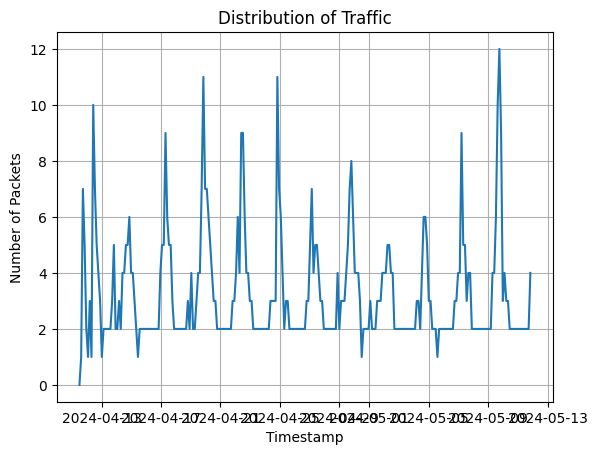

In [82]:
def plot_ts4prophet(x_values, y_values):
    plt.plot(x_values, y_values) 
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Packets')
    plt.title('Distribution of Traffic')
    plt.grid(True)
    plt.show()
    
plot_ts4prophet(augmented_timestamps, augmented_npackets)

In [83]:
output_data_file = os.path.join(WIRESHARK_INPUT_FOLDER, DEMO_FOLDER, INPUT_CSV_FILE + "_prophet_input.csv")
with open(output_data_file, "w+") as output_file:
    output_file.write("ds,y\r\n")
    for idx in range(0, len(timestamps) - 1):
        output_file.write(datetime.datetime.strftime(augmented_timestamps[idx], "%Y-%m-%d %H:%M:%S") + "," + str(augmented_npackets[idx]) + "\r\n")
    output_file.close()

In [84]:
df = pd.read_csv(output_data_file)
m = Prophet(changepoint_prior_scale=0.01).fit(df)

12:23:47 - cmdstanpy - INFO - Chain [1] start processing
12:23:47 - cmdstanpy - INFO - Chain [1] done processing


/home/gmazzucchi/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/gmazzucchi/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


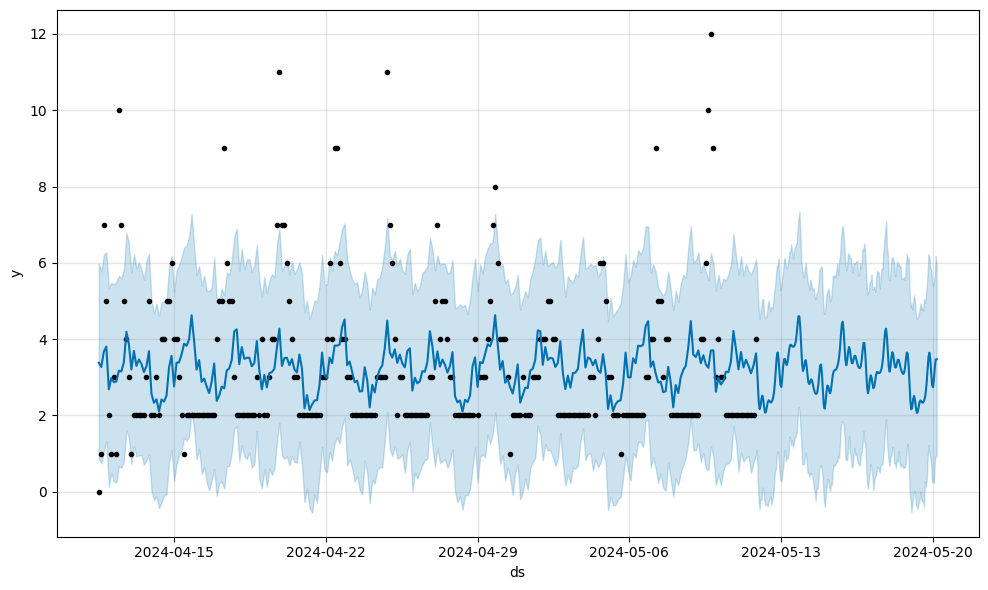

In [85]:
future = m.make_future_dataframe(periods=200, freq='h')
fcst = m.predict(future)
fig = m.plot(fcst)